# Self-Driving Car Engineer Nanodegree


## Project 1: **Finding Lane Lines on the Road** 


## Import Packages

In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[0, 0, 255], thickness=8):
    # Disclaimer: This section of the code is developed following 
    # instruction/suggestions/guideline offered in a video broadcasted by a Udacity Carnd tutor.
    
    # Define blank lists to capture right/left slope and right/left center
    rm = []
    lm = []
    rc = []
    lc = []
    
    # Capture height and width of image
    H = img.shape[0]
    W = img.shape[1]
    
    # Classify lines to either right or left based on slope.
    # Negative slope means left line, and positive means right.
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            slope  = (y2 - y1)/(x2 - x1)
            center = [ (x1 + x2)/2, (y1 + y2)/2]
            
            slope_min = 0.50
            slope_max = 0.80
            
            # Also ignore lines with unrealistic slope.
            if ( (abs(slope) > slope_min) and (abs(slope) < slope_max) and (slope != 0) ) :
                if slope < 0:
                    lm.append(slope)
                    lc.append(center)
                else:
                    rm.append(slope)
                    rc.append(center)
            else:
                continue
    
    # Find average of slope and center
    r_slope  = np.sum(rm)/len(rm)
    r_center = np.divide( np.sum(rc, axis=0), len(rc) )
    
    l_slope  = np.sum(lm)/len(lm)
    l_center = np.divide( np.sum(lc, axis=0), len(lc) )
    
    # Draw lines with averaged center and slope data
    # Also check for situation where we may not find any line in some frame of the video
    if ( (r_slope > 0) and (l_slope < 0) and (len(r_center) > 0) and (len(l_center) > 0) ):
        # Drawing lines (Left)
        x_c = int(l_center[0])
        y_c = int(l_center[1])
        x_1 = int(W*0.45)
        y_1 = int(y_c - l_slope*( x_c - x_1 ))
        y_2 = int(H)
        x_2 = int(x_c - ( y_c - y_2 )/l_slope)
        cv2.line(img, (x_1, y_1), (x_2, y_2), color, thickness)

        # Drawing lines (Right)
        x_c = int(r_center[0])
        y_c = int(r_center[1])
        x_1 = int(W*0.55)
        y_1 = int(y_c - r_slope*( x_c - x_1 ))
        y_2 = int(H)
        x_2 = int(x_c - ( y_c - y_2 )/r_slope)
        cv2.line(img, (x_1, y_1), (x_2, y_2), color, thickness)
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline

Building the pipeline and running the solution on all test_images.

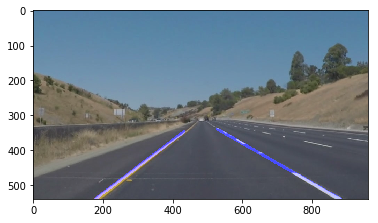

In [12]:
import os
files = os.listdir("test_images/")

for file in files:
    if file[0:6] != "output":
        img = mpimg.imread("test_images/"+file)
        
        # Converting to grayscale image
        gray = grayscale( img )  
        
        # Blurring image using Gaussian blurr method
        kernel_size = 7
        blur_gray = gaussian_blur( gray, kernel_size )
            
        # Detecting edge using Canny Edge detection method
        low_threshold = 40
        high_threshold = 160
        edges = canny( blur_gray, low_threshold, high_threshold )
        
        # Focus on region of interest
        H = img.shape[0]
        W = img.shape[1]
        vertices = np.array( [[( 0.05*W,H ), (0.49*W, 0.55*H), (0.51*W, 0.55*H), (0.95*W,H)]], dtype=np.int32)
        masked = region_of_interest( edges, vertices )
        
        # Find straight lines using hough transform
        rho = 1               # distance resolution in pixels of the Hough grid
        theta = np.pi/180     # angular resolution in radians of the Hough grid
        threshold = 35        # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 10   # minimum number of pixels making up a line
        max_line_gap = 1      # maximum gap in pixels between connectable line segments        
        lines = hough_lines( masked, rho, theta, threshold, min_line_length, max_line_gap )
                
        # Overlay on top of original
        result = weighted_img( lines, img, α=0.8, β=1.0)
        
        cv2.imwrite( "test_images/output_"+file, result )
        plt.imshow(result, cmap='gray')
        

Copying above lane finding pipeline to process_image() function

In [28]:
def process_image(image):
    
    # Converting to grayscale image
    gray = grayscale( image )  

    # Blurring image using Gaussian blurr method
    kernel_size = 7
    blur_gray = gaussian_blur( gray, kernel_size )

    # Detecting edge using Canny Edge detection method
    low_threshold = 40
    high_threshold = 160
    edges = canny( blur_gray, low_threshold, high_threshold )

    # Focus on region of interest
    H = img.shape[0]
    W = img.shape[1]
    vertices = np.array( [[( 0.05*W,H ), (0.49*W, 0.55*H), (0.51*W, 0.55*H), (0.95*W,H)]], dtype=np.int32)
    masked = region_of_interest( edges, vertices )

    # Find straight lines using hough transform
    rho = 1               # distance resolution in pixels of the Hough grid
    theta = np.pi/180     # angular resolution in radians of the Hough grid
    threshold = 35        # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10   # minimum number of pixels making up a line
    max_line_gap = 1      # maximum gap in pixels between connectable line segments        
    lines = hough_lines( masked, rho, theta, threshold, min_line_length, max_line_gap )

    # Overlay on top of original
    result = weighted_img( lines, image, α=0.8, β=1.0)

    return result

## Test on Videos


In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 64.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.05 s, sys: 837 ms, total: 3.89 s
Wall time: 3.92 s


In [31]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:11<00:00, 61.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.48 s, sys: 3.05 s, total: 12.5 s
Wall time: 11.6 s


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [32]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:08<00:00, 29.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.34 s, sys: 2.18 s, total: 8.52 s
Wall time: 9.34 s
